In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-review-data-new/marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv
/kaggle/input/walmart-review-data/WalmartProducts.csv


In [2]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import train_test_split #cross_val_score, GridSearchCV, cross_validate, train_test_split, RandomizedSearchCV
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word, TextBlob

import tensorflow as tf
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,TFBertForSequenceClassification
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

2024-02-26 17:38:01.244820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 17:38:01.244966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 17:38:01.368670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load Data**

In [3]:
walmart2 = pd.read_csv("../input/walmart-review-data-new/marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv")
#walmart2 is used as independent validation dataset
walmart = pd.read_csv("../input/walmart-review-data/WalmartProducts.csv")
print(walmart.shape)

(30006, 19)


# **Clean Data**

In [4]:
walmart = walmart.drop(columns=['Five Star','Four Star','Three Star','Two Star','One Star'])
print(walmart.shape)
walmart = walmart[walmart['Review'].notna()]
print(walmart.shape)
walmart=walmart.drop(columns=['Recommended Purchase'])
print(walmart.shape)

(30006, 14)
(25821, 14)
(25821, 13)


In [5]:
# transform to lower case
walmart['Review'] = walmart['Review'].str.lower()
# remove punctuations
walmart['Review'] = walmart['Review'].str.replace('[^\w\s]','',regex=True)
#remove number in the review text
walmart['Review'] = walmart['Review'].str.replace('\d', '', regex=True)
#remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
walmart['Review'] = walmart['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
#remove rare words: remove words only appearing one time
words_count = pd.Series(' '.join(walmart['Review']).split()).value_counts()
rare_word = words_count[words_count<=1]
walmart['Review'] = walmart['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Lemmatization:  reduces different inflected forms of words (like 'running' to 'run') to their base form.  
nltk.download('wordnet')
nltk.download('omw-1.4')
cmd = "unzip -d /usr/share/nltk_data/corpora/ /usr/share/nltk_data/corpora/wordnet.zip"
os.system(cmd)
os.system("ls /usr/share/nltk_data/corpora/wordnet*")


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

0

In [7]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
sentence = "The striped bats are hanging on their feet for best"
lemmatize_with_postag(sentence)

'The striped bat be hang on their foot for best'

In [8]:
walmart['Review'] = walmart['Review'].apply(lambda x: lemmatize_with_postag(x))

# **Binarization of Ratings**

In [10]:
#transform rating to positive and negative 
walmart["Senti"]=walmart["Rating"].apply(lambda x: "pos" if x > 3 else "neg")

In [11]:
senti_dict = {"pos": 1, "neg": 0}
walmart["label"] = walmart["Senti"].map(senti_dict)


<Axes: xlabel='label'>

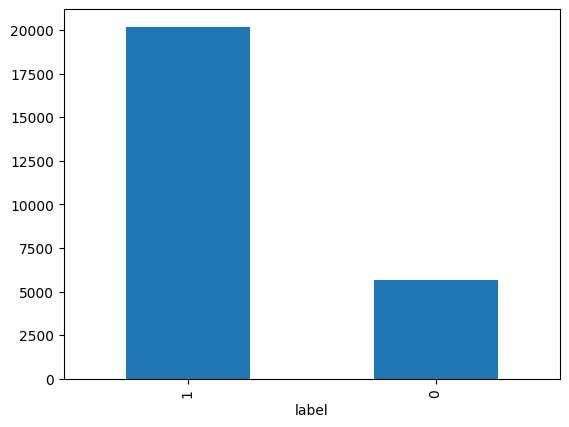

In [12]:
walmart["label"].value_counts().plot(kind="bar")

In [13]:
walmart["label"].value_counts()

label
1    20175
0     5646
Name: count, dtype: int64

# **Split the data into train, valid and test**

In [14]:
train_df = walmart.sample(frac=0.9, random_state=42)
test = walmart.drop(train_df.index)

In [15]:
train = train_df.sample(frac=0.78, random_state=42)
valid = train_df.drop(train.index)

In [26]:
np.array([train.label.value_counts(),valid.label.value_counts(),test.label.value_counts()]).T

array([[14093,  4015,  2067],
       [ 4033,  1098,   515]])

In [27]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train)
valid_ds = Dataset.from_pandas(valid)
test_ds = Dataset.from_pandas(test)

train_ds, valid_ds, test_ds

(Dataset({
     features: ['index', 'Uniq Id', 'Crawl Timestamp', 'Pageurl', 'Website', 'Title', 'Rating', 'Review', 'Reviewer Name', 'Review Upvotes', 'Review Downvotes', 'Verified Purchaser', 'Review Date', 'Senti', 'label', '__index_level_0__'],
     num_rows: 18126
 }),
 Dataset({
     features: ['index', 'Uniq Id', 'Crawl Timestamp', 'Pageurl', 'Website', 'Title', 'Rating', 'Review', 'Reviewer Name', 'Review Upvotes', 'Review Downvotes', 'Verified Purchaser', 'Review Date', 'Senti', 'label', '__index_level_0__'],
     num_rows: 5113
 }),
 Dataset({
     features: ['index', 'Uniq Id', 'Crawl Timestamp', 'Pageurl', 'Website', 'Title', 'Rating', 'Review', 'Reviewer Name', 'Review Upvotes', 'Review Downvotes', 'Verified Purchaser', 'Review Date', 'Senti', 'label', '__index_level_0__'],
     num_rows: 2582
 }))

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification,TrainingArguments, Trainer
from scipy.special import softmax

In [29]:
# importing the pretrained model's learned weights
model_name = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [32]:
# Evaluate using accuracy
from datasets import load_metric

accuracy = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [33]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
def preprocess_function(examples):
    return tokenizer(examples["Review"], truncation=True, max_length=128)

train_ds = train_ds.map(preprocess_function, batched=True)
valid_ds = valid_ds.map(preprocess_function, batched=True)
test_ds = test_ds.map(preprocess_function, batched=True)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [27]:
# To avoid some warnings on Kaggle notebook
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [35]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2,id2label=id2label, label2id=label2id,ignore_mismatched_sizes=True,return_dict=True)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly 

In [42]:
training_args = TrainingArguments(
    output_dir="roberta_sentiment_model",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

In [38]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.139800,0.443104,0.902406
2,0.183300,0.403492,0.904557
3,0.145000,0.434312,0.899863
4,0.118800,0.501945,0.897712
5,0.095100,0.561614,0.902992
6,0.068400,0.624734,0.899081
7,0.060000,0.631952,0.892627
8,0.039900,0.677753,0.899276
9,0.042000,0.681585,0.899863
10,0.031100,0.706873,0.902601


Checkpoint destination directory roberta_sentiment_model/checkpoint-1133 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory roberta_sentiment_model/checkpoint-2266 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory roberta_sentiment_model/checkpoint-3399 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=11330, training_loss=0.09027505072469956, metrics={'train_runtime': 1867.7819, 'train_samples_per_second': 97.046, 'train_steps_per_second': 6.066, 'total_flos': 7695479341612200.0, 'train_loss': 0.09027505072469956, 'epoch': 10.0})

In [44]:
predictions = trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=-1)
accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.9159566227730441}

In [45]:
print(classification_report(predictions.label_ids, preds))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       515
           1       0.94      0.95      0.95      2067

    accuracy                           0.92      2582
   macro avg       0.87      0.86      0.87      2582
weighted avg       0.91      0.92      0.92      2582



# **Independent Validation**

In [48]:
walmart2 = walmart2.drop(columns=['Five Star','Four Star','Three Star','Two Star','One Star'])
walmart2.shape

(28988, 13)

**Check the overlap with original data**

In [49]:
#overlap between walmart2 and walmart
overlap = set(walmart2["Uniq Id"]).intersection(set(walmart["Uniq Id"]))
len(overlap)

0

In [50]:
#remove overlap
walmart2 = walmart2[~walmart2["Uniq Id"].isin(overlap)]

**Run same data preprocess**

In [51]:
walmart2 = walmart2[walmart2['Review'].notna()]
walmart2.shape
walmart2=walmart2.drop(columns=['Recommended Purchase'])
walmart2.shape


(23609, 12)

In [52]:
# transform to lower case
walmart2['Review'] = walmart2['Review'].str.lower()
# remove punctuations
walmart2['Review'] = walmart2['Review'].str.replace('[^\w\s]','',regex=True)
#remove number in the review text
walmart2['Review'] = walmart2['Review'].str.replace('\d', '', regex=True)
#remove stopwords
walmart2['Review'] = walmart2['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
#remove rare words
words_count = pd.Series(' '.join(walmart2['Review']).split()).value_counts()
rare_word = words_count[words_count<=1]
walmart2['Review'] = walmart2['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))
walmart2['Review'] = walmart2['Review'].apply(lambda x: lemmatize_with_postag(x))

In [53]:
walmart2["Senti"]=walmart2["Rating"].apply(lambda x: "pos" if x > 3 else "neg")
walmart2["label"] = walmart2["Senti"].map(senti_dict)

<Axes: xlabel='label'>

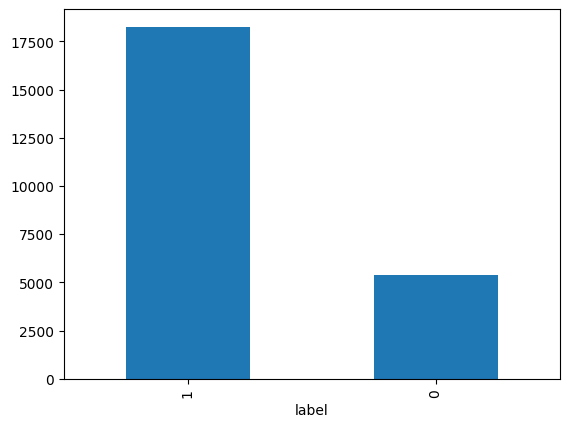

In [54]:
walmart2["label"].value_counts().plot(kind='bar')

In [55]:
walmart2["label"].value_counts()

label
1    18249
0     5360
Name: count, dtype: int64

In [56]:
walmart2_ds = Dataset.from_pandas(walmart2)

In [57]:
walmart2_ds = walmart2_ds.map(preprocess_function, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

In [58]:
predictions_walmart2 = trainer.predict(walmart2_ds)
preds_walmart2 = np.argmax(predictions_walmart2.predictions, axis=-1)
accuracy.compute(predictions=preds_walmart2, references=predictions_walmart2.label_ids)

{'accuracy': 0.9074081917912661}

In [59]:
print(classification_report(predictions_walmart2.label_ids, preds_walmart2))

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      5360
           1       0.93      0.96      0.94     18249

    accuracy                           0.91     23609
   macro avg       0.88      0.85      0.86     23609
weighted avg       0.90      0.91      0.91     23609



In [61]:
save_path="roberta_sentiment_model/checkpoint-11330"
!zip -r roberta_small.zip {save_path}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: roberta_sentiment_model/checkpoint-11330/ (stored 0%)
  adding: roberta_sentiment_model/checkpoint-11330/tokenizer.json (deflated 72%)
  adding: roberta_sentiment_model/checkpoint-11330/model.safetensors (deflated 7%)
  adding: roberta_sentiment_model/checkpoint-11330/trainer_state.json (deflated 77%)
  adding: roberta_sentiment_model/checkpoint-11330/config.json (deflated 49%)
  adding: roberta_sentiment_model/checkpoint-11330/vocab.json (deflated 59%)
  adding: roberta_sentiment_model/checkpoint-11330/merges.txt (deflated 53%)
  adding: roberta_sentiment_model/checkpoint-11330/optimizer.pt (deflated 32%)
  adding: roberta_sentiment_model/checkpoint-11330/training_args.bin (deflated 51%)
  adding: roberta_sentiment_model/checkpoint-11330/rng_state.pth (deflated 25%)
  adding: roberta_sentiment_model/checkpoint-11330/scheduler.pt (deflated 56%)
  adding: roberta_sentiment_model/checkpoint-11330/tokenizer_config.json (deflated 75%)
  adding: roberta_sentiment_model/checkpoint-